# Introduction to variational data assimilation
## Illustration of basic notions using the Lorenz 63 model


The objective of this notebook is to illustrate some basics of variational data assimilation, playing with a simple dynamical system, without going into detail about technical aspects.

The successive aspects that will be discussed are:

- Introduction of the Lorenz model
- Behavior of this model, illustration of its chaotic nature
- Linearized model, reference trajectory
- Variational data assimilation, with different sets of observations

### The Lorenz 63 model
Ed Lorenz proposed in 1963 a very simple 3-variable dynamical system, as an extremely simplified mathematical model of Rayleigh-Benard instability (atmospheric convection). This is this model that Ed Lorenz thoroughly studied and that made him introduce the famous *butterfly effect*. See https://en.wikipedia.org/wiki/Lorenz_system 

This model is a nonlinear system of three first-order ordinary differential equations. It reads:
$$
\left\{
\begin{array}{l}
\displaystyle{ \frac{ \hbox{d}x}{\hbox{d}t} = \sigma (y-x) } \\ 
\displaystyle{ \frac{ \hbox{d}y}{\hbox{d}t} = \rho x - y -x z  } \\ 
\displaystyle{ \frac{ \hbox{d}z}{\hbox{d}t} = -\beta z + x y   } \\
\end{array}
\right. 
$$

In the cell below, it is coded in a class with default parameters $\sigma = 10$, $\rho = 28$, $\beta=8/3$, and initial condition $(1.5, -1.5, 21)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#-------------------------------------------------------
# Lorenz 63 model
#-------------------------------------------------------

class Model:

    def __init__( self, nmembers = 1 ):
        self.nmembers = nmembers
        self.nx = 3                         # number of variables (Lorenz 63)
        self.sigma = 10.
        self.rho = 28.
        self.beta = 8./3.
        self.dt = 0.01
        self.x0 = np.array([1.5, -1.5, 20.])
        self.xvar = self.initial_condition(self.x0) 
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
        self.init_sup()
        
    def init_sup(self):
        # for child classes
        self.tangent=None
        
    def initial_condition(self,x0):
        """Define the initial condition"""
        if self.nmembers == 1:
            xout = x0.reshape((self.nx, 1))
        else:
            p0 = 3.*np.eye(self.nx)
            xout = np.random.multivariate_normal(x0, p0, self.nmembers).T
        return xout

    def rhs(self,x_in):
        """right hand side term of Lorenz 63"""
        x_out=np.zeros_like(x_in)
        x_out[0,]=self.sigma*(x_in[1,]-x_in[0,])
        x_out[1,]=self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,]
        x_out[2,]=x_in[0,]*x_in[1,]-self.beta*x_in[2,]
        return x_out

    def forward(self, nstep_in):
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            """ fourth-order Runge Kutta integration"""
            self.xvar_series[:,it,:] = self.xvar
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            k2=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            k3=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+k2
            k4=self.rhs(xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.time += self.dt
  
    def plot(self):
        plt.figure(figsize=(15,8))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            if ix==0: plt.ylabel("X component")
            if ix==1: plt.ylabel("Y component")
            if ix==2: 
                plt.ylabel("Z component")
                plt.xlabel("Time index (x 100)")
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.suptitle("X, Y and Z time series", fontweight='bold', fontsize=15)
        plt.show()

### Presentation of the Lorenz model dynamics

Below is a trajectory of the Lorenz system, plotted in the phase space (3D view and projection on the X-Z plane) and as X,Y and Z time series. We can clearly see its so-called "strange attractor" (i.e. a set of numerical values toward which the system tends to evolve, for a wide variety of initial conditions). Its shape looks like a butterfly, but nothing to do with the expression *butterfly effect*, which comes from the title of a presentation that Ed Lorenz gave in 1972 during the annual meeting of the American Association for the Advancement of Science: *Does the flap of a butterfly’s wings in Brazil set off a tornado in Texas?*. The system state sometimes switches from one wing of the butterfly to the other one, in a way which is extremely difficult to predict.

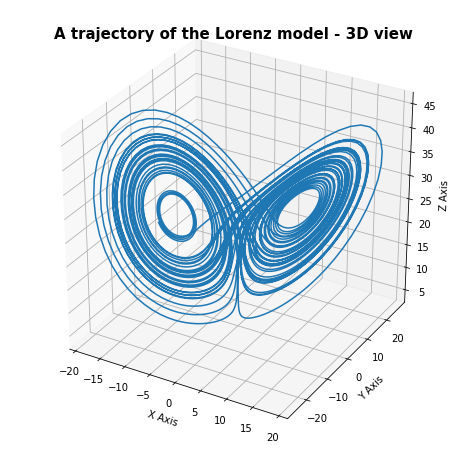

In [2]:
lorenz_test = Model()
lorenz_test.forward(5000)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[1,:,0], lorenz_test.xvar_series[2,:,0])
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("A trajectory of the Lorenz model - 3D view", fontweight='bold', fontsize=15)
plt.show()


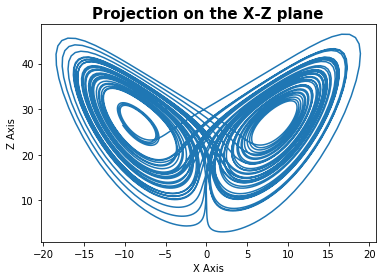

In [3]:
plt.figure()
plt.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[2,:,0], '-')
plt.xlabel("X Axis")
plt.ylabel("Z Axis")
plt.title("Projection on the X-Z plane", fontweight='bold', fontsize=15)
plt.show()

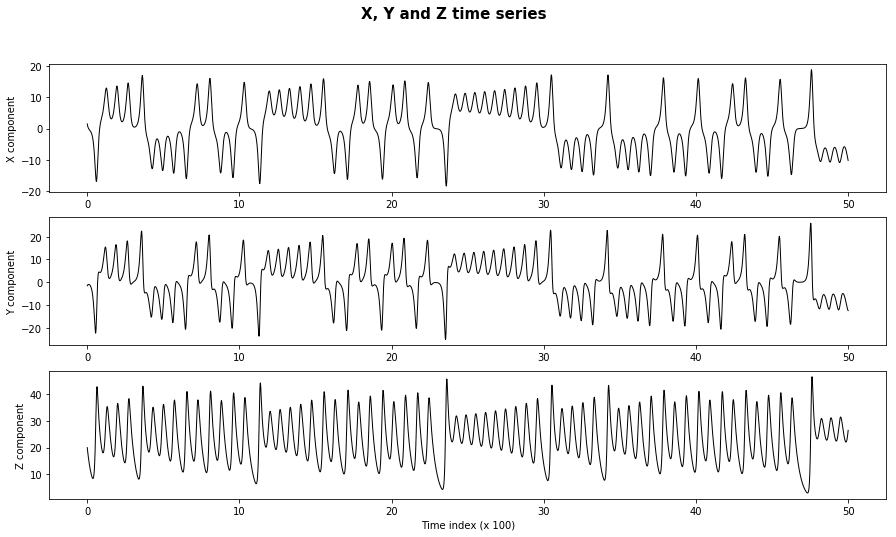

In [4]:
plt.figure()
lorenz_test.plot()
plt.show()

### Chaotic nature of the Lorenz system
Let now illustrate the chaotic nature of this system, i.e. its strong sensitivity to any small change in the initial condition.
Let first define the length of the integration time window (i.e. the number of time steps).

In [5]:
ntime = 1000

Let then define a so-called "reference simulation". In the following, this simulation will be supposed to be the true trajectory of the system, thus initialized with the true initial condition (1.5,−1.5,21). 


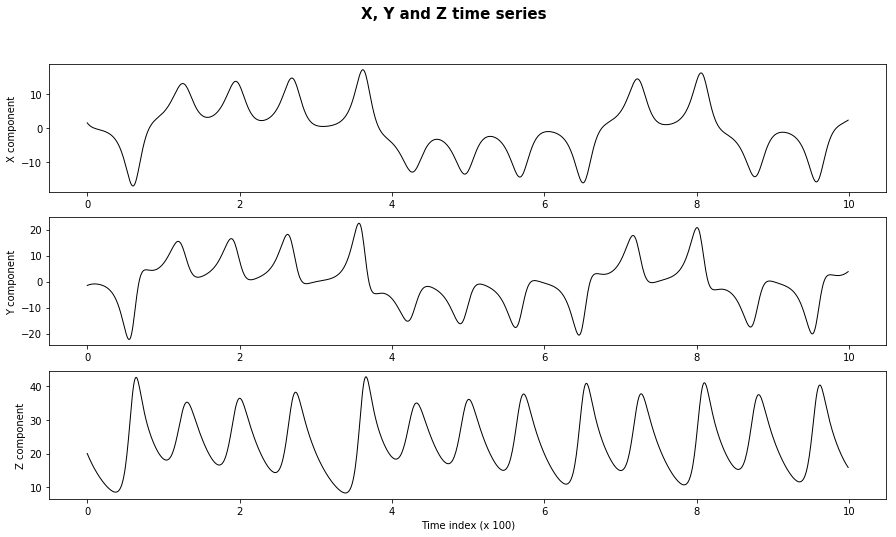

In [6]:
lorenz_ref = Model()
lorenz_ref.forward(ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

Let now define a perturbed initial condition, by changing a little bit x0 and y0:

In [7]:
wrong_state = np.array([3., -3., 21.])

and let observe how the model trajectory diverges from the reference one.

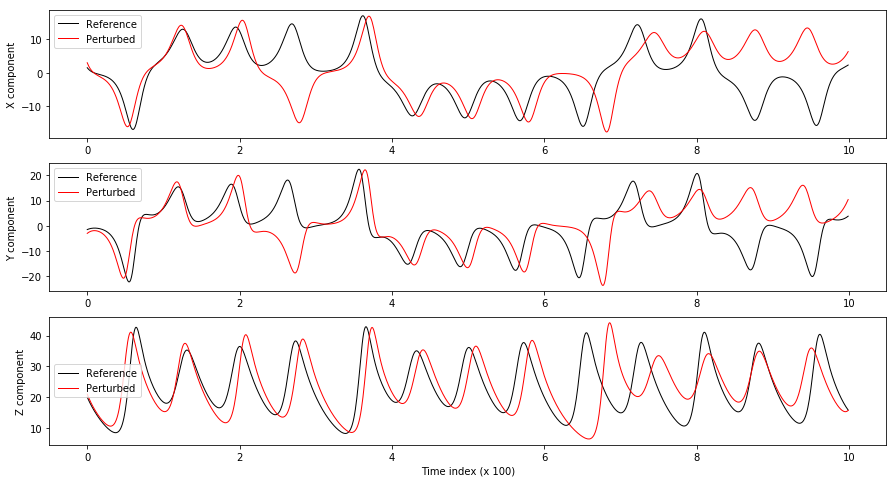

In [8]:
lorenz_test1 = Model()
lorenz_test1.x0 = np.copy(wrong_state)
lorenz_test1.xvar = lorenz_test1.initial_condition(lorenz_test1.x0)
lorenz_test1.forward(ntime)
plt.figure(figsize=(15,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    if ix==0: plt.ylabel("X component")
    if ix==1: plt.ylabel("Y component")
    if ix==2: 
        plt.ylabel("Z component")
        plt.xlabel("Time index (x 100)")
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.,label='Perturbed')
    plt.legend()
plt.show()

We can see for instance that, around time_step = 300, the reference solution moves on the right wing (x>0) while the perturbed solution moves on the left wing (x<0). Moreover, both solutions seem to become no longer correlated after roughly 700 or 800 time steps.

The divergence between these two trajectories can also be illustrated by computing the Euclidian norm of their difference: $$ E(t) = \left( \left(X_{pert} - X_{ref}\right)^2 + \left(Y_{pert} - Y_{ref}\right)^2 + \left(Z_{pert} - Z_{ref}\right)^2\right)^{1/2} $$

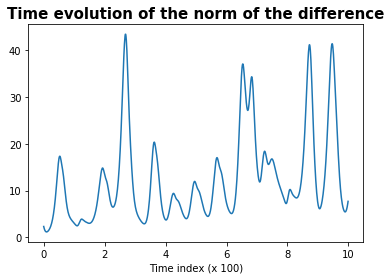

In [9]:
E = np.zeros(ntime)
for ix in range(3):
    E = E + (true_state[ix,:,0]-lorenz_test1.xvar_series[ix,:,0])**2
E=np.sqrt(E)
plt.xlabel("Time index (x 100)")
plt.title("Time evolution of the norm of the difference", fontweight='bold', fontsize=15)
plt.plot(true_time,E)
plt.show()

As can be seen, this evolution is far from a linear and regular increase... 

### Linearized (or tangent linear) model: another illustration of the effect of non linearities
Another way to illustrate the non-linear nature of this model is to linearize it about a given trajectory.

The linearized equations for the tangent variables $x_l,y_l,z_l$ are
$$
\left\{
\begin{array}{l}
\displaystyle{ \frac{ \hbox{d}x_l}{\hbox{d}t} = \sigma (y_l-x_l) } \\ 
\displaystyle{ \frac{ \hbox{d}y_l}{\hbox{d}t} = \rho x_l - y_l -x_l z-x z_l  } \\ 
\displaystyle{ \frac{ \hbox{d}z_l}{\hbox{d}t} = -\beta z_l + x_l y + x y_l   } \\
\end{array}
\right. 
$$
where $x,y,z$ satisfy the non linear equations


In [10]:
class Model_tan (Model):
    def init_sup(self):
        p0 = 3.*np.eye(self.nx)
        self.x0_tl = np.random.multivariate_normal([0., 0., 0.], p0, 1).T
        self.xvar_tl = self.initial_condition(self.x0_tl) 
        self.xvar_tl_series = []
        
    def rhs_tan(self,x_in, x_in_ref):
        """right hand side term of Lorenz 63, linearized about reference"""
        x_out=np.zeros_like(x_in)
        x_out[0,]=self.sigma*(x_in[1,]-x_in[0,])
        x_out[1,]=self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in_ref[2,]-x_in_ref[0,]*x_in[2,]
        x_out[2,]= x_in[0,]*x_in_ref[1,]+x_in_ref[0,]*x_in[1,]-self.beta*x_in[2,]
        return x_out  
    

    def forward_tan(self, nstep_in):
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.xvar_tl_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            """ fourth-order Runge Kutta integration"""
            self.xvar_series[:,it,:] = self.xvar
            self.xvar_tl_series[:,it,:] = self.xvar_tl
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            k1_tl=self.rhs_tan(self.xvar_tl,self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            xtmp_tl=self.xvar_tl+0.5*k1_tl
            k2=self.rhs(xtmp)*self.dt
            k2_tl=self.rhs_tan(xtmp_tl,xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            xtmp_tl=self.xvar_tl+0.5*k2_tl
            k3=self.rhs(xtmp)*self.dt
            k3_tl=self.rhs_tan(xtmp_tl,xtmp)*self.dt
            xtmp=self.xvar+k2
            xtmp_tl=self.xvar_tl+k2_tl
            k4=self.rhs(xtmp)*self.dt
            k4_tl=self.rhs_tan(xtmp_tl,xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.xvar_tl+=(k1_tl+2*k2_tl+2*k3_tl+k4_tl)/6.
            self.time += self.dt

    def plot_tan(self):
        plt.figure(figsize=(15,8))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            if ix==0: plt.ylabel("X component")
            if ix==1: plt.ylabel("Y component")
            if ix==2: 
                plt.ylabel("Z component")
                plt.xlabel("Time index (x 100)")
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_tl_series[ix,:,ie],'black',linewidth=1.)
        plt.suptitle("X, Y and Z time series", fontweight='bold', fontsize=15)
        plt.show()

We can then compare the time evolution of a small perturbation, propagated both by the non-linear and the linearized models

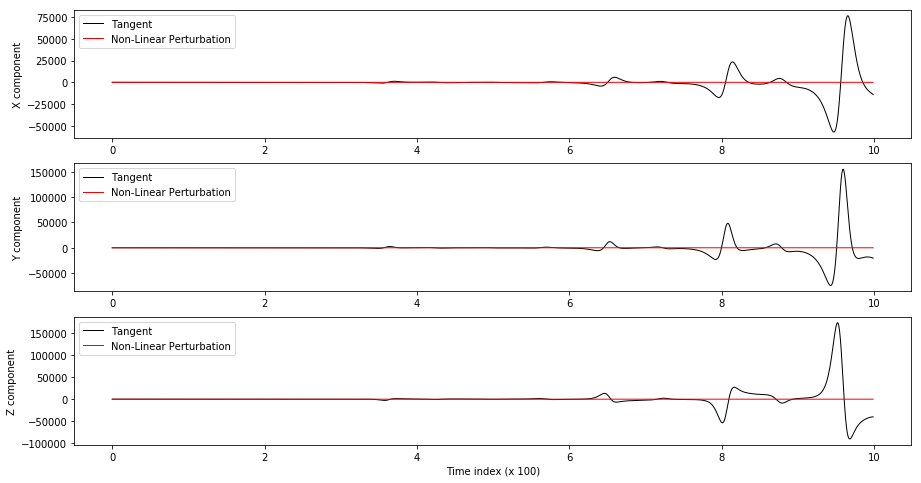

In [11]:
lorenz_tan=Model_tan()
lorenz_tan.forward_tan(ntime)
lorenz_dir=Model()
lorenz_dir.x0=lorenz_tan.xvar_tl_series[:,0,0]+true_state[:,0,0]
lorenz_dir.xvar = lorenz_dir.initial_condition(lorenz_dir.x0)
lorenz_dir.forward(ntime)

plt.figure(figsize=(15,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    if ix==0: plt.ylabel("X component")
    if ix==1: plt.ylabel("Y component")
    if ix==2: 
        plt.ylabel("Z component")
        plt.xlabel("Time index (x 100)")
    plt.plot(lorenz_tan.time_series,lorenz_tan.xvar_tl_series[ix,:,0],'black',linewidth=1.,label='Tangent')
    plt.plot(lorenz_dir.time_series,lorenz_dir.xvar_series[ix,:,0]-true_state[ix,:,0],'red',linewidth=1.,label='Non-Linear Perturbation')
    plt.legend()
plt.show()

While the non-linear model solution remains near the attractor, the linearized solution keeps growing.

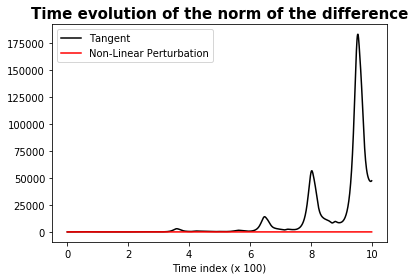

In [12]:
E1 = np.zeros(ntime)
E2 = np.zeros(ntime)
for ix in range(3):
    E1 = E1 + (true_state[ix,:,0]-lorenz_dir.xvar_series[ix,:,0])**2
    E2 = E2 + (lorenz_tan.xvar_tl_series[ix,:,0])**2
E1=np.sqrt(E1)
E2=np.sqrt(E2)
plt.xlabel("Time index (x 100)")
plt.title("Time evolution of the norm of the difference", fontweight='bold', fontsize=15)
plt.plot(true_time,E2,'black',label='Tangent')
plt.plot(true_time,E1,'red',label='Non-Linear Perturbation')
plt.legend()
plt.show()

### Data assimilation experiment
#### Observation operator
In this simple case, the observation operator is just a subsampling both in variables ($x$, $y$ and/or $z$) and time

In [13]:
class ObsOp:
    def __init__(self,xyzmask,timemask):
        self.xyzmask=xyzmask
        self.timemask=timemask

#### Cost function

The classical variational data assimilation cost function is defined as a weighted sum of background and observation squared departure

$$J(X_0)=\frac{\alpha}{2} \|X_0-X_0^b\|^2 + \frac{\beta}{2}\|H(X)-Y\|^2$$

In [14]:
def cost_function(xyz0, xyz_bkg, traj_obs, wgtb, wgto, H):
    
    obscost=0
    bkgcost=(np.linalg.norm(xyz0 - xyz_bkg))**2
    traj_mod=Model()
    traj_mod.x0=np.copy(xyz0)
    traj_mod.xvar = traj_mod.initial_condition(traj_mod.x0)
    traj_mod.forward(H.timemask[-1]+1)
    for var in H.xyzmask:
        obscost+=(np.linalg.norm(traj_mod.xvar_series[var,H.timemask]-traj_obs[var,H.timemask]))**2
    
    return 0.5*bkgcost*wgtb + 0.5*obscost*wgto
    

**_By playing with the observation operator settings below (assimilation window, density of observation), one can see its impact on the cost function shape_**

In [15]:
time_window=10     # assimilation window
xyzmask=[0]        # Which variables are observed
obstime=range(0,time_window,1) # Which time steps are observed
H=ObsOp(xyzmask,obstime)

A cross section of $J(x,y,z)$ along $y$ gives a hint on its convexity. This will singificantly impact the minimization behaviour.

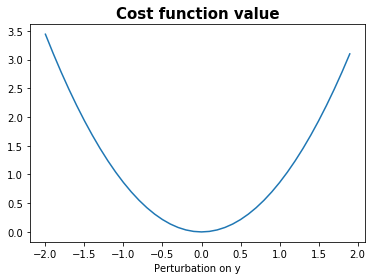

In [16]:
pert=np.arange(-2.,2.,0.1)
j=[]
for dy in pert:
    bkg=true_state[:,0,0]+np.array([0,dy,0])
    j.append(cost_function(bkg,true_state[:,0,0],true_state,.1,1.,H))

plt.xlabel("Perturbation on y")
plt.title("Cost function value", fontweight='bold', fontsize=15)
#plt.semilogy(pert,j)
plt.plot(pert,j)
plt.show()    

#### Minimization

The problem dimension being small enough (3 parameters to find) one can use efficient derivative-free optimization methods

In [17]:
import scipy.optimize as opt

bkg=np.copy(wrong_state)  # Background

res=opt.minimize(cost_function,bkg,args=(bkg,true_state,.1,1.,H), method='Powell')

print(res.message)
print('Number of iterations: ', res.nit)

ana=res.x # analysis

print('Truth:      ',true_state[:,0,0])
print('Background: ',bkg)
print('Analysis:   ',ana)

Optimization terminated successfully.
Number of iterations:  4
Truth:       [ 1.5 -1.5 20. ]
Background:  [ 3. -3. 21.]
Analysis:    [ 1.63461369 -1.74273697 20.94556879]


We can then plot the time evolution of the reference, background and analyzed trajectories. 

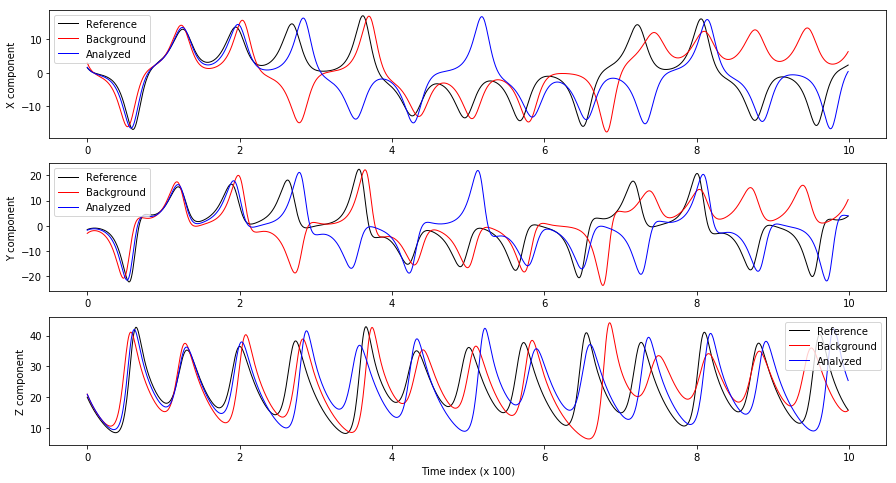

In [18]:
lorenz_opt = Model()
lorenz_opt.x0 = np.copy(ana)
lorenz_opt.xvar = lorenz_opt.initial_condition(lorenz_opt.x0)
lorenz_opt.forward(ntime)
plt.figure(figsize=(15,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    if ix==0: plt.ylabel("X component")
    if ix==1: plt.ylabel("Y component")
    if ix==2: 
        plt.ylabel("Z component")
        plt.xlabel("Time index (x 100)")
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.,label='Background')
    plt.plot(lorenz_opt.time_series,lorenz_opt.xvar_series[ix,:,0],'blue',linewidth=1.,label='Analyzed')
    plt.legend()
plt.show()